# Packages Used


In [ ]:
# General use
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
import collections
np.random.seed(42)
random.seed(42)


# Feature extraction 
from sklearn.model_selection import train_test_split
import re
import nltk
from sklearn.feature_extraction import text
stop_words_skt = text.ENGLISH_STOP_WORDS
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
# from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
wnl = WordNetLemmatizer()
porter = PorterStemmer()

# Dimension Reduction
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.utils.extmath import randomized_svd

# Classifier
from sklearn import metrics
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score 
from sklearn.metrics import roc_curve 
from sklearn.metrics import auc
from sklearn.metrics import f1_score 
import itertools

# Logistic Regression & Naive Bayes Model
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# Gridsearch 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from tempfile import mkdtemp
from shutil import rmtree
from joblib import Memory

# Multiclass SVM classification
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Loading Data

In [ ]:
#Load data
!gdown --id 12VLfuWtCS3NiGLsHyn0YiWqD-mZvBu4z
df = pd.read_csv("Project_1_dataset_01_01_2022.csv")
print("Data Shape: ", df.shape)

Downloading...
From: https://drive.google.com/uc?id=12VLfuWtCS3NiGLsHyn0YiWqD-mZvBu4z
To: /content/Project_1_dataset_01_01_2022.csv
100% 8.13M/8.13M [00:00<00:00, 37.1MB/s]
Data Shape:  (2072, 9)


# Getting Familiar with the Dataset

In [ ]:
def count_freq_alpha_numeric_chars(text):
  count = sum([c.isalnum() for c in text])
  return count


def plot_label_count(df, label_name):
  rst = collections.defaultdict(int)
  for _, row in df.iterrows():
    category = row[label_name]
    rst[category] += 1
  counts = [item[1] for item in list(rst.items())]
  plt.bar(range(len(rst.keys())), counts)
  plt.xticks(range(len(rst)), rst.keys(), rotation=90)
  plt.show()

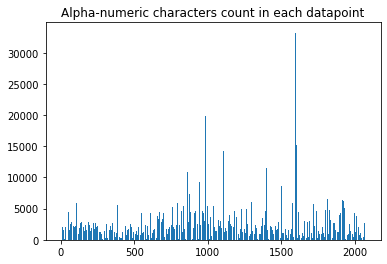

In [ ]:
alnum_full_text = [count_freq_alpha_numeric_chars(d) for d in df["full_text"]]
plt.bar(range(len(alnum_full_text)), alnum_full_text, label="alnum chars count")
plt.title("Alpha-numeric characters count in each datapoint")
plt.show()

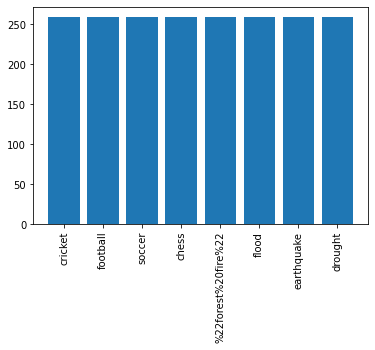

In [ ]:
plot_label_count(df, "leaf_label")

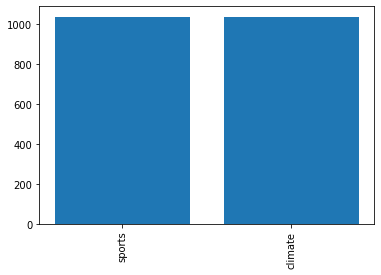

In [ ]:
plot_label_count(df, "root_label")

# Splitting the entire dataset into training and testing data

In [ ]:
train_raw, test_raw = train_test_split(df[["full_text", "root_label"]], test_size = 0.2)
print("Train Shape: ", train_raw.shape, " --- Test Shape: ", test_raw.shape)

Train Shape:  (1657, 2)  --- Test Shape:  (415, 2)


### Question 2

*   Based on the result above, the training data has 1657 samples, and the testing data has 415 samples. 


# Feature Extraction

In [ ]:
def clean(text):
  text = text.lower()
  text = re.sub(r'\d+', '', text)
  text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
  texter = re.sub(r"<br />", " ", text)
  texter = re.sub(r"&quot;", "\"",texter)
  texter = re.sub('&#39;', "\"", texter)
  texter = re.sub('\n', " ", texter)
  texter = re.sub(' u '," you ", texter)
  texter = re.sub('`',"", texter)
  texter = re.sub(' +', ' ', texter)
  texter = re.sub(r"(!)\1+", r"!", texter)
  texter = re.sub(r"(\?)\1+", r"?", texter)
  texter = re.sub('&amp;', 'and', texter)
  texter = re.sub('\r', ' ',texter)
  clean = re.compile('<.*?>')
  texter = texter.encode('ascii', 'ignore').decode('ascii')
  texter = re.sub(clean, '', texter)
  if texter == "":
    texter = ""
  return texter

def get_wordnet_pos(tag):
  if tag[0] == 'J':
    return wordnet.ADJ
  elif tag[0] == 'V':
    return wordnet.VERB
  elif tag[0] == 'R':
    return wordnet.ADV
  else:
    return wordnet.NOUN
    
def stemming(text):
  text_stemmed = []
  for t in text:
    tokens = word_tokenize(t)
    words = [porter.stem(word) for word in tokens]
    sentence = ' '.join(words)
    text_stemmed.append(sentence)
  return text_stemmed

def lemmatize(text):
  text_lemmatized = []
  for t in text:
    tokens = word_tokenize(t)
    words = [wnl.lemmatize(word,(get_wordnet_pos(tag))) \
             for word, tag in pos_tag(tokens) \
             if wnl.lemmatize(word,(get_wordnet_pos(tag))).isalpha()]
    sentence = ' '.join(words)
    text_lemmatized.append(sentence) 
  return text_lemmatized

def clean_dataset_by_label(dataset, label, clean_funct):
  t1 = time.time()
  print("Cleaning dataset by label: '{}'".format(label))
  dataset[label] = dataset.applymap(clean_funct)
  print("Completed cleaning in %f sec\n" %(time.time()-t1))

def lemmatize_dataset_by_label(dataset, label, lemma_funct):
  t1 = time.time()
  print("Lemmatizing dataset by label: '{}'".format(label))
  dataset[label] = lemma_funct(dataset[label])
  print("Completed Lemmatizing in %f sec\n" %(time.time()-t1))

def report_TFIDF_matrix_shape(train, test, min_df, label):
  count_vect = CountVectorizer(min_df=min_df,stop_words="english")
  X_train = count_vect.fit_transform(train[label])
  X_test = count_vect.transform(test[label])
  tfidf = TfidfTransformer()
  train_tfidf_matrix = tfidf.fit_transform(X_train).toarray()
  test_tfidf_matrix = tfidf.transform(X_test).toarray() 
  print("Shape of train matrix using min_df = {} : {}".format(min_df, train_tfidf_matrix.shape))
  print("Shape of test matrix using min_df = {} : {}".format(min_df, test_tfidf_matrix.shape))
  return train_tfidf_matrix, test_tfidf_matrix

In [ ]:
# Clean data
print("=========== Cleaning Data ===========")
train = train_raw.applymap(clean)
test = test_raw.applymap(clean)
print("=========== Done Cleaning ===========\n")

#lemmatize training and testing data
print("===========  Lemmatizing  ===========")
train['full_text'] = lemmatize(train['full_text'])
test['full_text'] = lemmatize(test['full_text'])
print("========== Done Lemmatizing =========\n")

# How does varying min df change the TF-IDF matrix (Question 3.2)
print("=========== Varing min_df ===========")
for min_df in range(1,5):
  report_TFIDF_matrix_shape(train, test, min_df, "full_text")
print()

# Use min_df=3
print("=========== When min_df=3 ===========")
count_vect = CountVectorizer(min_df=3,stop_words="english")
X_train = count_vect.fit_transform(train['full_text'])
X_test = count_vect.transform(test['full_text'])
tfidf = TfidfTransformer()
X_train_tfidf_matrix = tfidf.fit_transform(X_train).toarray() 
X_test_tfidf_matrix = tfidf.transform(X_test).toarray() 

print(X_train_tfidf_matrix.shape)
print(X_test_tfidf_matrix.shape)

=========== Cleaning Data ===========
=========== Done Cleaning ===========

===========  Lemmatizing  ===========
========== Done Lemmatizing =========

=========== Varing min_df ===========
Shape of train matrix using min_df = 1 : (1657, 27255)
Shape of test matrix using min_df = 1 : (415, 27255)
Shape of train matrix using min_df = 2 : (1657, 13399)
Shape of test matrix using min_df = 2 : (415, 13399)
Shape of train matrix using min_df = 3 : (1657, 9614)
Shape of test matrix using min_df = 3 : (415, 9614)
Shape of train matrix using min_df = 4 : (1657, 7760)
Shape of test matrix using min_df = 4 : (415, 7760)

=========== When min_df=3 ===========
(1657, 9614)
(415, 9614)


# Dimensionality Reduction

In [ ]:
# Question 4.1
Ks = [1, 10, 50, 100, 200, 500, 1000, 2000]
lsi = TruncatedSVD(n_components = 2000,n_iter = 10, random_state = 42)
lsi_train = lsi.fit_transform(X_train_tfidf_matrix)
lsi_test = lsi.transform(X_test_tfidf_matrix)
cumulative_evr = np.array([lsi.explained_variance_ratio_[:i].sum() for i in range(1, 2001)])
markers = [cumulative_evr[k - 1] for k in Ks]

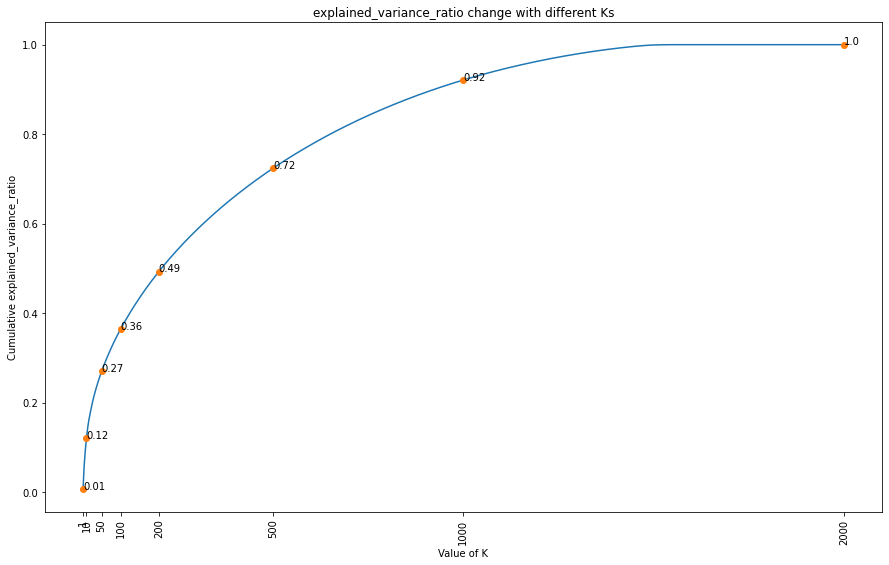

In [ ]:
plt.figure(figsize=(15,9))
plt.plot(range(1, 2001), cumulative_evr)
plt.plot(Ks, markers, ls="", marker="o", label="points")
for K, evr in zip(Ks, markers):
  plt.text(K, evr, str(round(evr, 2)))
plt.title('explained_variance_ratio change with different Ks')
plt.xlabel("Value of K")
plt.ylabel("Cumulative explained_variance_ratio")
plt.xticks(Ks, rotation = 90)
plt.show()

In [ ]:
# Question 4.2
u,sigma,vt = randomized_svd(X_train_tfidf_matrix,n_components=50,random_state=42)
x_50 = np.dot(np.dot(u,np.diag(sigma)),vt)
lsi_mse = np.sqrt(np.sum(np.square(x_50 - X_train_tfidf_matrix)))
print("MSE Error for LSI: \n" + str(lsi_mse))

# NMF
nmf = NMF(n_components=50, init='random', random_state=42, max_iter=500)
nmf_train = nmf.fit_transform(X_train_tfidf_matrix)
nmf_test = nmf.transform(X_test_tfidf_matrix)
WH = np.dot(nmf_train, nmf.components_)
nmf_mse = np.sqrt(np.sum(np.square(WH-X_train_tfidf_matrix)))
print("MSE Error for NMF: \n" + str(nmf_mse))


MSE Error for LSI: 
34.387326032132854
MSE Error for NMF: 
34.707447044710854


# Classification Algorithm

## Map Labels to Binary

In [ ]:
# Construct lsi data with k=50
lsi = TruncatedSVD(n_components = 50,n_iter = 10, random_state = 42)
lsi_train = lsi.fit_transform(X_train_tfidf_matrix)
lsi_test = lsi.transform(X_test_tfidf_matrix)

# Construct labels
mapping = {'sports': 1, 'climate': 0}
train_svm = train
train_svm = train_svm.replace({'root_label': mapping})
train_svm_label = train_svm['root_label'].to_numpy()
print(train_svm_label.shape)

test_svm = test
test_svm = test_svm.replace({'root_label': mapping})
test_svm_label = test_svm['root_label'].to_numpy()
print(test_svm_label.shape)

(1657,)
(415,)


## Support Vector Machines (SVM)

In [ ]:
def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          classes = ['sports', 'climate']
):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

def get_fpr_tpr(labels, prob_func):
  fpr, tpr, _ = roc_curve(labels, prob_func)
  return fpr, tpr

def report_svm(C, lsi_train, lsi_test, train_svm_label, test_svm_label):
  svc = svm.SVC(C = C, probability=True, kernel='linear')
  svc.fit(lsi_train, train_svm_label)
  svc_predicted = svc.predict(lsi_test)

  print('gamma: '+ str(C))
  print('Accuracy: ' + str(metrics.accuracy_score(test_svm_label.ravel(), svc_predicted)))
  print('Precision: ' + str(metrics.precision_score(test_svm_label.ravel(), svc_predicted, zero_division=1)))
  print('Recall: ' + str(metrics.recall_score(test_svm_label.ravel(), svc_predicted, zero_division=1)))
  print('F-1 Score: ' + str(metrics.f1_score(test_svm_label.ravel(), svc_predicted, zero_division=1)))

  #compute confusion matrix
  cnf_matrix = metrics.confusion_matrix(test_svm_label, svc_predicted)
  np.set_printoptions(precision=2)

  # Plot confusion matrix
  plt.figure()
  plot_confusion_matrix(
      cnf_matrix, 
      title='Confusion matrix for r = {} SVM, without normalization'.format(C)
  )

  #ROC Curve
  # probs = svc.predict_proba(lsi_test)[: ,1]
  # fpr, tpr, _ = roc_curve(test_svm_label, probs)
  # fpr, tpr, _ = roc_curve(test_svm_label.ravel(), svc_predicted)
  fpr, tpr = get_fpr_tpr(test_svm_label, svc.decision_function(lsi_test))  
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, color = 'b', label='ROC curve (area = %0.4f)' % roc_auc)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title("ROC Curve for C = {} SVM".format(C))
  plt.legend(loc="lower right")
  plt.show()
  return fpr, tpr

gamma: 1000
Accuracy: 0.9686746987951808
Precision: 0.971830985915493
Recall: 0.9672897196261683
F-1 Score: 0.9695550351288057
Confusion matrix, without normalization
[[195   6]
 [  7 207]]


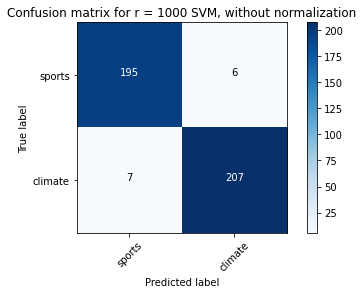

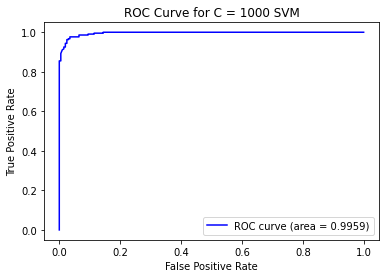

gamma: 0.0001
Accuracy: 0.4843373493975904
Precision: 1.0
Recall: 0.0
F-1 Score: 0.0
Confusion matrix, without normalization
[[201   0]
 [214   0]]


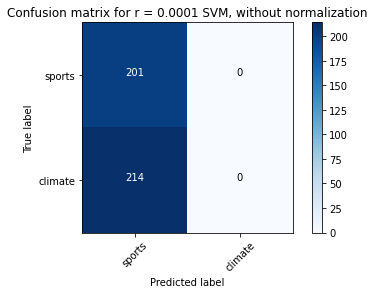

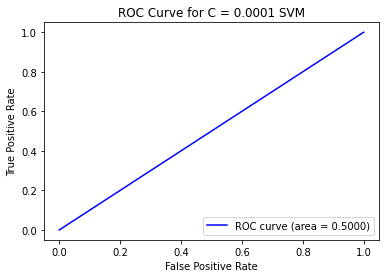

gamma: 100000
Accuracy: 0.9686746987951808
Precision: 0.976303317535545
Recall: 0.9626168224299065
F-1 Score: 0.9694117647058823
Confusion matrix, without normalization
[[196   5]
 [  8 206]]


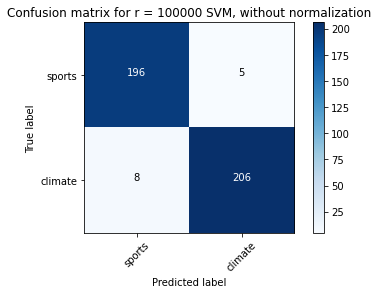

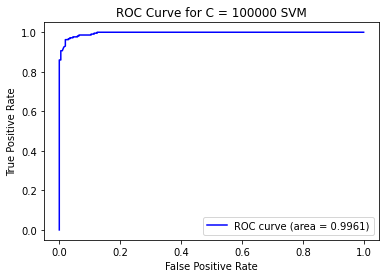

In [ ]:
fpr_100000, tpr_100000 = report_svm(100000, lsi_train, lsi_test, train_svm_label, test_svm_label) # super hard
fpr_hard, tpr_hard = report_svm(1000, lsi_train, lsi_test, train_svm_label, test_svm_label)       # hard
fpr_soft, tpr_soft = report_svm(0.0001, lsi_train, lsi_test, train_svm_label, test_svm_label)     # soft

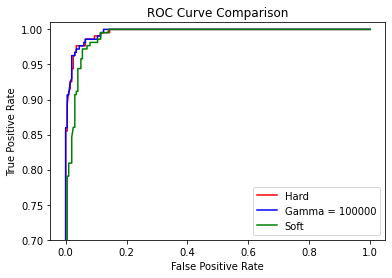

In [ ]:
#ROC comparison
plt.gcf().clear()
plt.plot(fpr_hard, tpr_hard, color = 'r', label = 'Hard')
plt.plot(fpr_100000, tpr_100000, color = 'b', label = 'Gamma = 100000')
plt.plot(fpr_soft, tpr_soft, color = 'g', label = 'Soft')
# plt.xlim(0,0.2)
plt.ylim(0.7,1.01)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve Comparison")
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
plt.gcf().clear()
svc_cv = GridSearchCV(estimator=SVC(probability=True, kernel='linear'),param_grid={'C': [10**k for k in range(-3,7,1)]},cv = 5)
svc_cv.fit(lsi_train, train_svm_label)

GridSearchCV(cv=5, estimator=SVC(kernel='linear', probability=True),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000,
                               100000, 1000000]})

<Figure size 432x288 with 0 Axes>

In [ ]:
#Result of CV
pd.DataFrame(svc_cv.cv_results_)[['param_C','mean_test_score']].sort_values(by=['mean_test_score'], ascending=False)

,param_C,mean_test_score
4,10,0.964400
5,100,0.964396
6,1000,0.958958
3,1,0.956557
7,10000,0.955946
8,100000,0.952925
9,1000000,0.952923
2,0.1,0.944493
0,0.001,0.502715
1,0.01,0.502715


gamma: 10
Accuracy: 0.9759036144578314
Precision: 0.9671361502347418
Recall: 0.9856459330143541
F-1 Score: 0.976303317535545
Confusion matrix, without normalization
[[199   7]
 [  3 206]]


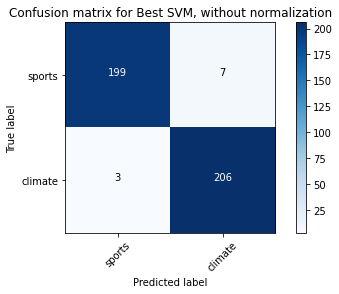

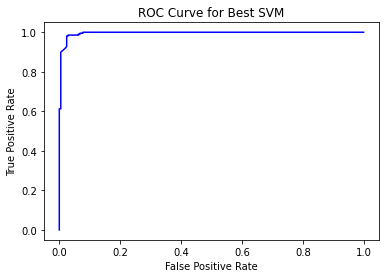

In [ ]:
# Best SVM with CV

svc_best = svm.SVC(C = svc_cv.best_params_['C'], probability=True, kernel='linear')
svc_best.fit(lsi_train, train_svm_label)
svc_best_predicted = svc_best.predict(lsi_test)

print('gamma: '+ str(svc_cv.best_params_['C']))
print('Accuracy: ' + str(metrics.accuracy_score(test_svm_label.ravel(), svc_best_predicted)))
print('Precision: ' + str(metrics.precision_score(test_svm_label.ravel(), svc_best_predicted)))
print('Recall: ' + str(metrics.recall_score(test_svm_label.ravel(), svc_best_predicted)))
print('F-1 Score: ' + str(metrics.f1_score(test_svm_label.ravel(), svc_best_predicted)))


#compute confusion matrix
cnf_best_matrix = metrics.confusion_matrix(test_svm_label, svc_best_predicted)
np.set_printoptions(precision=2)

# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_best_matrix, title='Confusion matrix for Best SVM, without normalization')
plt.show() 

#ROC Curve
# fpr_best, tpr_best, _ = roc_curve(test_svm_label.ravel(), svc_best_predicted)
fpr, tpr = get_fpr_tpr(test_svm_label, svc_best.decision_function(lsi_test))  
plt.plot(fpr, tpr, color = 'b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve for Best SVM")
plt.show()

## Logistic Regression

Accuracy: 0.9614457831325302
Precision: 0.9502262443438914
Recall: 0.9767441860465116
F-1 Score: 0.963302752293578
Confusion matrix, without normalization
[[189  11]
 [  5 210]]


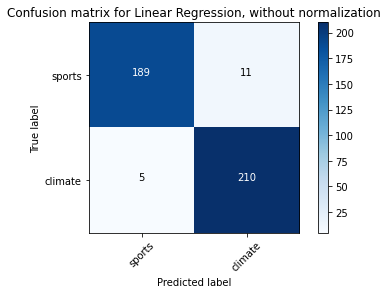

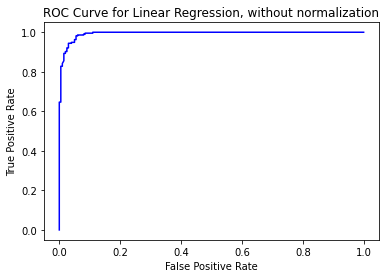

In [ ]:
#without regularization
lr_no_regularization = LogisticRegression()
lr_no_regularization.fit(lsi_train, train_svm_label)
lr_no_regularization_predicted = lr_no_regularization.predict(lsi_test)

print('Accuracy: ' + str(metrics.accuracy_score(test_svm_label.ravel(), lr_no_regularization_predicted)))
print('Precision: ' + str(metrics.precision_score(test_svm_label.ravel(), lr_no_regularization_predicted)))
print('Recall: ' + str(metrics.recall_score(test_svm_label.ravel(), lr_no_regularization_predicted)))
print('F-1 Score: ' + str(metrics.f1_score(test_svm_label.ravel(), lr_no_regularization_predicted)))


#compute confusion matrix
cnf_lr_no_regularization_matrix = metrics.confusion_matrix(test_svm_label, lr_no_regularization_predicted)
np.set_printoptions(precision=2)

# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_lr_no_regularization_matrix, 
                      title='Confusion matrix for Linear Regression, without normalization'
                      )
plt.show() 

#ROC Curve
# fpr_lr_no_regularization, tpr_lr_no_regularization, _ = roc_curve(test_svm_label.ravel(), lr_no_regularization_predicted)
fpr_lr_no_regularization, tpr_lr_no_regularization = get_fpr_tpr(test_svm_label, lr_no_regularization.decision_function(lsi_test))
plt.plot(fpr_lr_no_regularization, tpr_lr_no_regularization, color = 'b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve for Linear Regression, without normalization")
plt.show()

In [ ]:
logistic_param = {'C':[10**i for i in range(-4, 5, 1)]}
logistic_l1 = LogisticRegression(penalty="l1", solver='liblinear')
logistic_l1_grid = GridSearchCV(logistic_l1, logistic_param,cv=5) 
logistic_l1_grid.fit(lsi_train, train_svm_label)

pd.DataFrame(logistic_l1_grid.cv_results_)[['param_C','mean_test_score']].sort_values(by=['mean_test_score'], ascending=False)

,param_C,mean_test_score
5,10,0.962569
6,100,0.960761
4,1,0.957145
7,1000,0.956539
8,10000,0.956539
3,0.1,0.913688
0,0.0001,0.504526
1,0.001,0.504526
2,0.01,0.504526


Accuracy: 0.9614457831325302
Precision: 0.9627906976744186
Recall: 0.9627906976744186
F-1 Score: 0.9627906976744186
Confusion matrix, without normalization
[[192   8]
 [  8 207]]


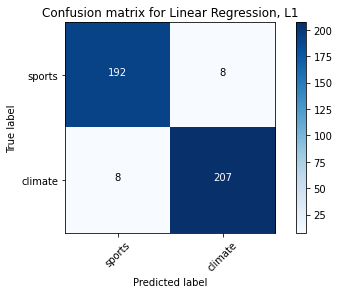

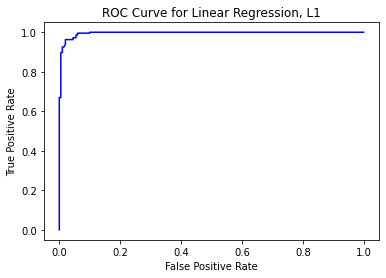

In [ ]:
lr_l1 = LogisticRegression(penalty="l1", C=logistic_l1_grid.best_params_['C'], solver='liblinear')
lr_l1.fit(lsi_train, train_svm_label)
lr_l1_predicted = lr_l1.predict(lsi_test)

print('Accuracy: ' + str(metrics.accuracy_score(test_svm_label.ravel(), lr_l1_predicted)))
print('Precision: ' + str(metrics.precision_score(test_svm_label.ravel(), lr_l1_predicted)))
print('Recall: ' + str(metrics.recall_score(test_svm_label.ravel(), lr_l1_predicted)))
print('F-1 Score: ' + str(metrics.f1_score(test_svm_label.ravel(), lr_l1_predicted)))


#compute confusion matrix
cnf_lr_l1_matrix = metrics.confusion_matrix(test_svm_label, lr_l1_predicted)
np.set_printoptions(precision=2)

# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_lr_l1_matrix, title='Confusion matrix for Linear Regression, L1')
plt.show() 

#ROC Curve
# fpr_lr_l1, tpr_lr_l1, _ = roc_curve(test_svm_label.ravel(), lr_l1_predicted)
fpr_lr_l1, tpr_lr_l1 = get_fpr_tpr(test_svm_label, lr_l1.decision_function(lsi_test))
plt.plot(fpr_lr_l1, tpr_lr_l1, color = 'b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve for Linear Regression, L1")
plt.show()

In [ ]:
logistic_l2 = LogisticRegression(penalty="l2", max_iter=1000)
logistic_l2_grid = GridSearchCV(logistic_l2, logistic_param,cv=5) 
logistic_l2_grid.fit(lsi_train, train_svm_label)

pd.DataFrame(logistic_l2_grid.cv_results_)[['param_C','mean_test_score']].sort_values(by=['mean_test_score'], ascending=False)

,param_C,mean_test_score
6,100,0.960159
5,10,0.959558
7,1000,0.959553
8,10000,0.957142
4,1,0.956534
3,0.1,0.952916
2,0.01,0.943863
1,0.001,0.513575
0,0.0001,0.504526


Accuracy: 0.9590361445783132
Precision: 0.9583333333333334
Recall: 0.9627906976744186
F-1 Score: 0.9605568445475637
Confusion matrix, without normalization
[[191   9]
 [  8 207]]


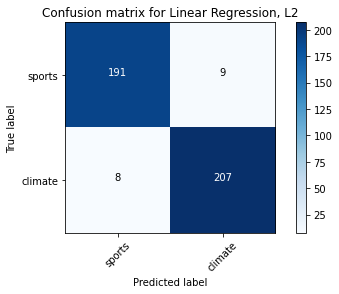

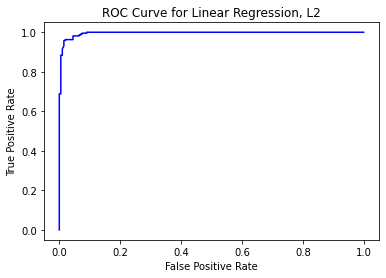

In [ ]:
lr_l2 = LogisticRegression(penalty="l2", C=logistic_l2_grid.best_params_['C'], max_iter=1000)
lr_l2.fit(lsi_train, train_svm_label)
lr_l2_predicted = lr_l2.predict(lsi_test)

print('Accuracy: ' + str(metrics.accuracy_score(test_svm_label.ravel(), lr_l2_predicted)))
print('Precision: ' + str(metrics.precision_score(test_svm_label.ravel(), lr_l2_predicted)))
print('Recall: ' + str(metrics.recall_score(test_svm_label.ravel(), lr_l2_predicted)))
print('F-1 Score: ' + str(metrics.f1_score(test_svm_label.ravel(), lr_l2_predicted)))


#compute confusion matrix
cnf_lr_l2_matrix = metrics.confusion_matrix(test_svm_label, lr_l2_predicted)
np.set_printoptions(precision=2)

# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_lr_l2_matrix, title='Confusion matrix for Linear Regression, L2')
plt.show() 

#ROC Curve
fpr_lr_l2, tpr_lr_l2 = get_fpr_tpr(test_svm_label, lr_l2.decision_function(lsi_test))
plt.plot(fpr_lr_l2, tpr_lr_l2, color = 'b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve for Linear Regression, L2")
plt.show()

## Naive Bayes Model

Accuracy: 0.944578313253012
Precision: 0.9736842105263158
Recall: 0.9113300492610837
F-1 Score: 0.9414758269720103
Confusion matrix, without normalization
[[207   5]
 [ 18 185]]


<Figure size 432x288 with 0 Axes>

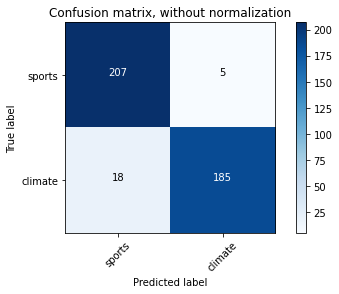

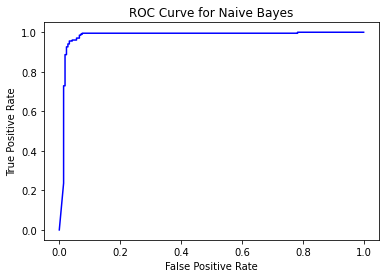

In [ ]:
plt.gcf().clear()
gnb = GaussianNB()
gnb.fit(lsi_train, train_svm_label)
pred = gnb.predict(lsi_test)

print('Accuracy: ' + str(metrics.accuracy_score(test_svm_label.ravel(), pred)))
print('Precision: ' + str(metrics.precision_score(test_svm_label.ravel(), pred)))
print('Recall: ' + str(metrics.recall_score(test_svm_label.ravel(), pred)))
print('F-1 Score: ' + str(metrics.f1_score(test_svm_label.ravel(), pred)))

#compute confusion matrix
cnf_matrix = metrics.confusion_matrix(test_svm_label, pred)
np.set_printoptions(precision=2)

# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix,
                  title='Confusion matrix, without normalization')
plt.show() 

# calculate fpr_tpr
bayes_pred = gnb.predict_proba(lsi_test)[:,1]
fpr, tpr,_ = roc_curve(test_svm_label.ravel(), bayes_pred)
plt.plot(fpr, tpr, color = 'b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve for Naive Bayes")
plt.show()

# Grid Search of Parameters

## Pipeline & grid_param

In [ ]:
# Create a temporary folder to store the transformers of the pipeline
location = "cachedir"
memory = Memory(location=location, verbose=10)


# Delete the temporary cache before exiting
memory.clear(warn=False)
rmtree(location)

In [ ]:
###############################################
#           Pipelin and options               #
# 1. cleaning vs not cleaning (two pipelines) #
# 2. Feature Extraction (min_df = 3 vs. 5)    #
# 3. LSI vs. NMF (k = [5, 50, 500])           #
# 4. Best SVM vs. Logistic vs. GaussianNB     #
###############################################
pipe = Pipeline(steps=[
  ("vect", CountVectorizer(stop_words='english')),
  ("tfidf", TfidfTransformer()),
  ("dim_reduction", TruncatedSVD()),
  ("classifier", SVC())
], memory = memory)

In [ ]:
#for k = 5, 50
param_grid = {
    "vect__min_df": [3, 5],
    "dim_reduction": [TruncatedSVD(n_components=5,random_state=42), 
                      TruncatedSVD(n_components=50,random_state=42),
                      #TruncatedSVD(n_components=500,random_state=42),
                      NMF(n_components=5,init='random', random_state=42),
                      NMF(n_components=50,init='random', random_state=42)],
                      #NMF(n_components=500,init='random', random_state=42),
    "classifier": [SVC(C=svc_cv.best_params_['C'],random_state=42), 
                   LogisticRegression(penalty='l2',C=logistic_l2_grid.best_params_['C'],random_state=42),
                   LogisticRegression(penalty='l1',C=logistic_l1_grid.best_params_['C'],random_state=42,solver = 'liblinear'), 
                   GaussianNB()]
}

#with k= 500
param_grid_500 = {
    "vect__min_df": [3, 5],
    "dim_reduction": [TruncatedSVD(n_components=500,random_state=42),
                      NMF(n_components=500,init='random', random_state=42)],
    "classifier": [SVC(C=svc_cv.best_params_['C'],random_state=42), 
                   LogisticRegression(penalty='l2',C=logistic_l2_grid.best_params_['C'],random_state=42),
                   LogisticRegression(penalty='l1',C=logistic_l1_grid.best_params_['C'],random_state=42,solver = 'liblinear'), 
                   GaussianNB()]
}

## Lemmatizing & Without Cleaning

### Without Cleaning & k = 5, 50

In [ ]:
#Data without cleaning for k = 5, 50
train_raw['full_text'] = lemmatize(train_raw['full_text'])
grid_no_cleaning = GridSearchCV(pipe, cv=5 , n_jobs = -1, param_grid = param_grid, scoring = 'accuracy')
grid_no_cleaning.fit(train_raw['full_text'],train_svm_label)
result_no_cleaning = pd.DataFrame(grid_no_cleaning.cv_results_)


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(min_df=3, stop_words='english'), 1874    A new campaign online on billboard and over th...
590     The Hatchets put up a fight but in the end Eve...
1314    Frankie be LOVING Tsunami Sushi The roll he ha...
538     LAS VEGAS KTNV Parts of four city soccer pitch...
334     BLACKSBURG Jack Coan s play in the first quart...
                              ...                        
813     We ve talk about who the best chess player be ...
344     Mississippi State coach Mike Leach receive his...
1863    article The Minnesota Department of Natural Re...
986     Do we still need to talk about Tennessee No Co...
587     campaigner have accuse FIFA of stay silent dur...
Name: full_text, Length: 1657, dtype: object, 
array([0, ..., 1]), None, message_clsname='Pipeline', message=None)
__________________________________________

In [ ]:
#The result for data without cleaning for k=5, 50
result_no_cleaning[["param_classifier", 
                    "param_dim_reduction", 
                    "param_vect__min_df", 
                    "mean_test_score"]
                   ].sort_values(by=['mean_test_score'], ascending=False).head()

### Without Cleaning & k = 500

In [ ]:
#Run data without cleaning GridSearch for k=500
grid_no_cleaning_500 = GridSearchCV(pipe, cv=5 , n_jobs = -1, param_grid = param_grid_500, scoring = 'accuracy')
grid_no_cleaning_500.fit(train_raw['full_text'],train_svm_label)
result_no_cleaning_500 = pd.DataFrame(grid_no_cleaning_500.cv_results_)

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from cachedir/joblib/sklearn/pipeline/_fit_transform_one/eaf43115753163b7d30bbc8fd2c1479f
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from cachedir/joblib/sklearn/pipeline/_fit_transform_one/cb6c59abdcb15b4ffa22fcd7a4b8afad
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(n_components=500, random_state=42), <1657x9846 sparse matrix of type '<class 'numpy.float64'>'
	with 213866 stored elements in Compressed Sparse Row format>, 
array([0, ..., 1]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 3.1s, 0.1min


In [ ]:
#The result for data without cleaning
result_no_cleaning_500[["param_classifier", 
                    "param_dim_reduction", 
                    "param_vect__min_df", 
                    "mean_test_score"]
                   ].sort_values(by=['mean_test_score'], ascending=False).head()

,param_classifier,param_dim_reduction,param_vect__min_df,mean_test_score
0,"SVC(C=10, random_state=42)","TruncatedSVD(n_components=500, random_state=42)",3,0.976471
4,"LogisticRegression(C=100, random_state=42)","TruncatedSVD(n_components=500, random_state=42)",3,0.975869
5,"LogisticRegression(C=100, random_state=42)","TruncatedSVD(n_components=500, random_state=42)",5,0.974659
1,"SVC(C=10, random_state=42)","TruncatedSVD(n_components=500, random_state=42)",5,0.974056
7,"LogisticRegression(C=100, random_state=42)","NMF(init='random', n_components=500, random_st...",5,0.971039


### Without Cleaning Final Result

In [ ]:
#Concatenate : The final result with data without cleaning
result_no_cleaning_best = pd.concat([result_no_cleaning,result_no_cleaning_500])
result_no_cleaning_best[["param_classifier", 
                    "param_dim_reduction", 
                    "param_vect__min_df", 
                    "mean_test_score"]
                   ].sort_values(by=['mean_test_score'], ascending=False).head()

,param_classifier,param_dim_reduction,param_vect__min_df,mean_test_score
0,"SVC(C=10, random_state=42)","TruncatedSVD(n_components=500, random_state=42)",3,0.976471
4,"LogisticRegression(C=100, random_state=42)","TruncatedSVD(n_components=500, random_state=42)",3,0.975869
5,"LogisticRegression(C=100, random_state=42)","TruncatedSVD(n_components=500, random_state=42)",5,0.974659
1,"SVC(C=10, random_state=42)","TruncatedSVD(n_components=500, random_state=42)",5,0.974056
7,"LogisticRegression(C=100, random_state=42)","NMF(init='random', n_components=500, random_st...",5,0.971039


## Lemmatizing & With Cleaning

### With Cleaning & k = 5, 50

In [ ]:
#Data with cleaning for k = 5, 50
grid_w_cleaning = GridSearchCV(pipe, cv=5 , n_jobs = -1, param_grid = param_grid, scoring = 'accuracy')
grid_w_cleaning.fit(train['full_text'],train_svm_label)
result_w_cleaning = pd.DataFrame(grid_w_cleaning.cv_results_)

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(min_df=5, stop_words='english'), 1874    a new campaign online on billboard and over th...
590     the hatchet put up a fight but in the end ever...
1314    frankie be love tsunami sushi the roll he have...
538     la vega ktnv part of four city soccer pitch be...
334     blacksburg jack coans play in the first quarte...
                              ...                        
813     weve talk about who the best chess player be a...
344     mississippi state coach mike leach receive his...
1863    article the minnesota department of natural re...
986     do we still need to talk about tennessee no co...
587     campaigner have accuse fifa of stay silent dur...
Name: full_text, Length: 1657, dtype: object, 
array([0, ..., 1]), None, message_clsname='Pipeline', message=None)
__________________________________________

In [ ]:
#The result for data with cleaning for k=5, 50
result_w_cleaning[["param_classifier", 
                    "param_dim_reduction", 
                    "param_vect__min_df", 
                    "mean_test_score"]
                   ].sort_values(by=['mean_test_score'], ascending=False).head()

,param_classifier,param_dim_reduction,param_vect__min_df,mean_test_score
3,"SVC(C=10, random_state=42)","TruncatedSVD(n_components=50, random_state=42)",5,0.966813
30,GaussianNB(),"NMF(init='random', n_components=50, random_sta...",3,0.966220
19,"LogisticRegression(C=10, penalty='l1', random_...","TruncatedSVD(n_components=50, random_state=42)",5,0.966210
11,"LogisticRegression(C=100, random_state=42)","TruncatedSVD(n_components=50, random_state=42)",5,0.965608
2,"SVC(C=10, random_state=42)","TruncatedSVD(n_components=50, random_state=42)",3,0.965002


### With Cleaning & k = 500

In [ ]:
#Run data with cleaning GridSearch for k=500
grid_w_cleaning_500 = GridSearchCV(pipe, cv=5 , n_jobs = -1, param_grid = param_grid_500, scoring = 'accuracy')
grid_w_cleaning_500.fit(train['full_text'],train_svm_label)
result_w_cleaning_500 = pd.DataFrame(grid_w_cleaning_500.cv_results_)

In [ ]:
#The result for data with cleaning for k=500
result_w_cleaning_500[["param_classifier", 
                    "param_dim_reduction", 
                    "param_vect__min_df", 
                    "mean_test_score"]
                   ].sort_values(by=['mean_test_score'], ascending=False).head()

,param_classifier,param_dim_reduction,param_vect__min_df,mean_test_score
6,"LogisticRegression(C=100, random_state=42)","NMF(init='random', n_components=500, random_st...",3,0.974662
4,"LogisticRegression(C=100, random_state=42)","TruncatedSVD(n_components=500, random_state=42)",3,0.974058
0,"SVC(C=10, random_state=42)","TruncatedSVD(n_components=500, random_state=42)",3,0.972852
1,"SVC(C=10, random_state=42)","TruncatedSVD(n_components=500, random_state=42)",5,0.972852
9,"LogisticRegression(C=10, penalty='l1', random_...","TruncatedSVD(n_components=500, random_state=42)",5,0.972245


### With Cleaning Final Result

In [ ]:
#Concatenate : The final result with data with cleaning
result_w_cleaning_best = pd.concat([result_w_cleaning,result_w_cleaning_500])
result_w_cleaning_best[["param_classifier", 
                    "param_dim_reduction", 
                    "param_vect__min_df", 
                    "mean_test_score"]
                   ].sort_values(by=['mean_test_score'], ascending=False).head()

,param_classifier,param_dim_reduction,param_vect__min_df,mean_test_score
6,"LogisticRegression(C=100, random_state=42)","NMF(init='random', n_components=500, random_st...",3,0.974662
4,"LogisticRegression(C=100, random_state=42)","TruncatedSVD(n_components=500, random_state=42)",3,0.974058
0,"SVC(C=10, random_state=42)","TruncatedSVD(n_components=500, random_state=42)",3,0.972852
1,"SVC(C=10, random_state=42)","TruncatedSVD(n_components=500, random_state=42)",5,0.972852
9,"LogisticRegression(C=10, penalty='l1', random_...","TruncatedSVD(n_components=500, random_state=42)",5,0.972245


## Stemming & Without Cleaning

In [ ]:
# With stemming
train_raw, test_raw = train_test_split(df[["full_text", "root_label"]], test_size = 0.2)
porter = PorterStemmer()
train_raw['full_text'] = stemming(train_raw['full_text'])

In [ ]:
# Construct labels
mapping = {'sports': 1, 'climate': 0}
train_stemming = train_raw
train_stemming = train_stemming.replace({'root_label': mapping})
train_stemming_label = train_stemming['root_label'].to_numpy()

test_stemming = test_raw
test_stemming= test_stemming.replace({'root_label': mapping})
test_stemming_label = test_stemming['root_label'].to_numpy()

In [ ]:
def gridsearch_result(train, train_label, param_grid):
  grid_stem = GridSearchCV(pipe, 
                           cv=5, 
                           n_jobs = -1, 
                           param_grid = param_grid,
                           scoring = 'accuracy')
  grid_stem.fit(train['full_text'], train_label)
  result_df = pd.DataFrame(grid_stem.cv_results_)
  return grid_stem, result_df

def display_gridsearch_df(df):
  return df[["param_classifier", 
      "param_dim_reduction", 
      "param_vect__min_df", 
      "mean_test_score"]
      ].sort_values(by=['mean_test_score'], ascending=False).head()

### Without Cleaning & k = 5, 50

In [ ]:
#param grid reload
#for k = 5, 50
param_grid_stemming = {
    "vect__min_df": [3, 5],
    "dim_reduction": [TruncatedSVD(n_components=5,random_state=42), 
                      TruncatedSVD(n_components=50,random_state=42),
                      #TruncatedSVD(n_components=500,random_state=42),
                      NMF(n_components=5,init='random', random_state=42),
                      NMF(n_components=50,init='random', random_state=42)],
                      #NMF(n_components=500,init='random', random_state=42),
    "classifier": [SVC(C=10,random_state=42), 
                   LogisticRegression(penalty='l2',C=100,random_state=42),
                   LogisticRegression(penalty='l1',C=10,random_state=42,solver = 'liblinear'), 
                   GaussianNB()]
}

#with k= 500
param_grid_500_stemming = {
    "vect__min_df": [3, 5],
    "dim_reduction": [TruncatedSVD(n_components=500,random_state=42),
                      NMF(n_components=500,init='random', random_state=42)],
    "classifier": [SVC(C=10,random_state=42), 
                   LogisticRegression(penalty='l2',C=100,random_state=42),
                   LogisticRegression(penalty='l1',C=10,random_state=42,solver = 'liblinear'), 
                   GaussianNB()]
}

In [ ]:
# Data without cleaning for k = 5, 50
grid_no_cleaning_stem, result_no_cleaning_stem = gridsearch_result(train_raw, train_stemming_label, param_grid_stemming)
display_gridsearch_df(result_no_cleaning_stem)

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from cachedir/joblib/sklearn/pipeline/_fit_transform_one/d8ed7f4384a6caaea9e92b312506f7b3
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from cachedir/joblib/sklearn/pipeline/_fit_transform_one/b33cec944f08d50035da92f13a3b29aa
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from cachedir/joblib/sklearn/pipeline/_fit_transform_one/f0a2e0128d8c37647a50ff453af2b455
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


,param_classifier,param_dim_reduction,param_vect__min_df,mean_test_score
31,GaussianNB(),"NMF(init='random', n_components=50, random_sta...",5,0.966196
30,GaussianNB(),"NMF(init='random', n_components=50, random_sta...",3,0.963178
10,"LogisticRegression(C=100, random_state=42)","TruncatedSVD(n_components=50, random_state=42)",3,0.962583
11,"LogisticRegression(C=100, random_state=42)","TruncatedSVD(n_components=50, random_state=42)",5,0.962583
19,"LogisticRegression(C=10, penalty='l1', random_...","TruncatedSVD(n_components=50, random_state=42)",5,0.962583


### Without Cleaning & k = 500

In [ ]:
# Data without cleaning for k = 5, 50
grid_no_cleaning_stem_500, result_no_cleaning_stem_500 = gridsearch_result(train_raw, train_stemming_label, param_grid_500_stemming)
display_gridsearch_df(result_no_cleaning_stem_500)

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(min_df=3, stop_words='english'), 428     lsu agre to $ 17m buyout with coach O ; univer...
1920    will the seriou drought condit afflict larg sw...
543     frankfurt , germani ( AP ) — bundesliga club m...
1917    A drought across north carolina is show no sig...
1067    cnn 's hada gold speak with an isra forest fir...
                              ...                        
1146    NT govern alert level : watch and act – there ...
754     pragu ( AP ) — A postpon women ’ s world cup q...
1537    meteorologist kristi steward 's first warn for...
2003    de moin , iowa -- drought condit are eas sligh...
1977    with governor gavin newsom declar a statewid d...
Name: full_text, Length: 1657, dtype: object, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)
__________________________________________

,param_classifier,param_dim_reduction,param_vect__min_df,mean_test_score
4,"LogisticRegression(C=100, random_state=42)","TruncatedSVD(n_components=500, random_state=42)",3,0.978273
5,"LogisticRegression(C=100, random_state=42)","TruncatedSVD(n_components=500, random_state=42)",5,0.978273
0,"SVC(C=10, random_state=42)","TruncatedSVD(n_components=500, random_state=42)",3,0.975258
9,"LogisticRegression(C=10, penalty='l1', random_...","TruncatedSVD(n_components=500, random_state=42)",5,0.973443
1,"SVC(C=10, random_state=42)","TruncatedSVD(n_components=500, random_state=42)",5,0.972238


### Without Cleaning Final Result

In [ ]:
#Concatenate : The final result with data without cleaning
result_wo_cleaning_stem_best = pd.concat([result_no_cleaning_stem,result_no_cleaning_stem_500])
display_gridsearch_df(result_wo_cleaning_stem_best)

,param_classifier,param_dim_reduction,param_vect__min_df,mean_test_score
4,"LogisticRegression(C=100, random_state=42)","TruncatedSVD(n_components=500, random_state=42)",3,0.978273
5,"LogisticRegression(C=100, random_state=42)","TruncatedSVD(n_components=500, random_state=42)",5,0.978273
0,"SVC(C=10, random_state=42)","TruncatedSVD(n_components=500, random_state=42)",3,0.975258
9,"LogisticRegression(C=10, penalty='l1', random_...","TruncatedSVD(n_components=500, random_state=42)",5,0.973443
1,"SVC(C=10, random_state=42)","TruncatedSVD(n_components=500, random_state=42)",5,0.972238


## Stemming & With Cleaning 

In [ ]:
# With stemming
train_raw, test_raw = train_test_split(df[["full_text", "root_label"]], test_size = 0.2)
train_cleaned = train_raw.applymap(clean)
test_cleaned = test_raw.applymap(clean)
train_cleaned['full_text'] = stemming(train_raw['full_text'])
test_cleaned['full_text'] = stemming(test_raw['full_text'])

### With Cleaning & k = 5, 50

In [ ]:
# Data with cleaning for k = 5, 50
grid_w_cleaning_stem, result_w_cleaning_stem = gridsearch_result(train_cleaned, train_stemming_label, param_grid_stemming)
display_gridsearch_df(result_w_cleaning_stem)

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(min_df=3, stop_words='english'), 631     caden mcduffi , senior – footbal • fitzpatrick...
1037    nillumbik shire council ha acknowledg the work...
753     three star on their uniform , one for each con...
547     union — even though holmdel senior alexandra w...
1008    latest version of legaci of the dragon , a hig...
                              ...                        
256     daryl mitchel and jame neesham power new zeala...
1717    watch the full interview now as a vladtv youtu...
711     electron art and fifa are in a bit of a cost d...
793     malaysia playground equip market size , landsc...
709     © luke mccullough follow hi first goal for gle...
Name: full_text, Length: 1657, dtype: object, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)
__________________________________________

,param_classifier,param_dim_reduction,param_vect__min_df,mean_test_score
28,GaussianNB(),"NMF(init='random', n_components=5, random_stat...",3,0.520196
24,GaussianNB(),"TruncatedSVD(n_components=5, random_state=42)",3,0.517186
25,GaussianNB(),"TruncatedSVD(n_components=5, random_state=42)",5,0.516584
30,GaussianNB(),"NMF(init='random', n_components=50, random_sta...",3,0.511176
29,GaussianNB(),"NMF(init='random', n_components=5, random_stat...",5,0.506312


### With Cleaning & k = 500

In [ ]:
# Data with cleaning for k = 500
grid_w_cleaning_stem_500, result_w_cleaning_stem_500 = gridsearch_result(train_cleaned, train_stemming_label, param_grid_500_stemming)

In [ ]:
display_gridsearch_df(result_w_cleaning_stem_500)

,param_classifier,param_dim_reduction,param_vect__min_df,mean_test_score
7,"LogisticRegression(C=100, random_state=42)","NMF(init='random', n_components=500, random_st...",5,0.512973
14,GaussianNB(),"NMF(init='random', n_components=500, random_st...",3,0.508752
3,"SVC(C=10, random_state=42)","NMF(init='random', n_components=500, random_st...",5,0.508163
15,GaussianNB(),"NMF(init='random', n_components=500, random_st...",5,0.505742
11,"LogisticRegression(C=10, penalty='l1', random_...","NMF(init='random', n_components=500, random_st...",5,0.502710


### With Cleaning Final Result

In [ ]:
#Concatenate : The final result with data with cleaning
result_w_cleaning_stem_best = pd.concat([result_w_cleaning_stem,result_w_cleaning_stem_500])
display_gridsearch_df(result_w_cleaning_stem_best)

,param_classifier,param_dim_reduction,param_vect__min_df,mean_test_score
28,GaussianNB(),"NMF(init='random', n_components=5, random_stat...",3,0.520196
24,GaussianNB(),"TruncatedSVD(n_components=5, random_state=42)",3,0.517186
25,GaussianNB(),"TruncatedSVD(n_components=5, random_state=42)",5,0.516584
7,"LogisticRegression(C=100, random_state=42)","NMF(init='random', n_components=500, random_st...",5,0.512973
30,GaussianNB(),"NMF(init='random', n_components=50, random_sta...",3,0.511176


## With Nothing & Without Cleaning

In [ ]:
train_raw, test_raw = train_test_split(df[["full_text", "root_label"]], test_size = 0.2)

### Without Cleaning & k = 5, 50

In [ ]:
# Data with cleaning for k = 5, 50
grid_no_cleaning_nothing, result_no_cleaning_nothing = gridsearch_result(train_raw, train_stemming_label, param_grid_stemming)
display_gridsearch_df(result_no_cleaning_nothing)

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(min_df=3, stop_words='english'), 1333    CORPUS CHRISTI, Texas — We’ll have more sunshi...
1519    Drenching rain and whipping winds are sweeping...
603     Country\n\nUnited States of America US Virgin ...
1187    Despite several days of rain in October, Calif...
1118    NSW Department of Planning, Industry and Envir...
                              ...                        
292     INGLEWOOD, Calif. — The Tennessee Titans will ...
1143    Copyright © 2021 Albuquerque Journal\n\nWhen w...
97      South African captain Temba Bavuma said he has...
1464    Meteorologist Myles Henderson’s First Warning ...
1036    CHELMSFORD -- Residents can get a first look a...
Name: full_text, Length: 1657, dtype: object, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)
__________________________________________

,param_classifier,param_dim_reduction,param_vect__min_df,mean_test_score
30,GaussianNB(),"NMF(init='random', n_components=50, random_sta...",3,0.505731
7,"SVC(C=10, random_state=42)","NMF(init='random', n_components=50, random_sta...",5,0.504517
16,"LogisticRegression(C=10, penalty='l1', random_...","TruncatedSVD(n_components=5, random_state=42)",3,0.502723
8,"LogisticRegression(C=100, random_state=42)","TruncatedSVD(n_components=5, random_state=42)",3,0.497894
9,"LogisticRegression(C=100, random_state=42)","TruncatedSVD(n_components=5, random_state=42)",5,0.497891


### Without Cleaning & k = 500

In [ ]:
# Data with cleaning for k = 500
grid_no_cleaning_nothing_500, result_no_cleaning_nothing_500 = gridsearch_result(train_raw, train_stemming_label, param_grid_500_stemming)
display_gridsearch_df(result_no_cleaning_nothing_500)

### Without Cleaning Final Result

In [ ]:
# Concatenate : The final result with data without cleaning
result_no_cleaning_nothing_best = pd.concat([result_no_cleaning_nothing,result_no_cleaning_nothing_500])
display_gridsearch_df(result_no_cleaning_nothing_best)

,param_classifier,param_dim_reduction,param_vect__min_df,mean_test_score
30,GaussianNB(),"NMF(init='random', n_components=50, random_sta...",3,0.505731
7,"SVC(C=10, random_state=42)","NMF(init='random', n_components=50, random_sta...",5,0.504517
16,"LogisticRegression(C=10, penalty='l1', random_...","TruncatedSVD(n_components=5, random_state=42)",3,0.502723
10,"LogisticRegression(C=10, penalty='l1', random_...","NMF(init='random', n_components=500, random_st...",3,0.497902
8,"LogisticRegression(C=100, random_state=42)","TruncatedSVD(n_components=5, random_state=42)",3,0.497894


## With Nothing & With Cleaning

In [ ]:
train_cleaned = train_raw.applymap(clean)
test_cleaned = test_raw.applymap(clean)

### With Cleaning & k = 5, 50

In [ ]:
# Data with cleaning for k = 5, 50
grid_w_cleaning_nothing, result_w_cleaning_nothing = gridsearch_result(train_cleaned, train_stemming_label, param_grid_stemming)
display_gridsearch_df(result_w_cleaning_nothing)

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(min_df=5, stop_words='english'), 1333    corpus christi, texas  well have more sunshine...
1519    drenching rain and whipping winds are sweeping...
603     country united states of america us virgin isl...
1187    despite several days of rain in october, calif...
1118    nsw department of planning, industry and envir...
                              ...                        
292     inglewood, calif.  the tennessee titans will h...
1143    copyright  albuquerque journal when wildfire s...
97      south african captain temba bavuma said he has...
1464    meteorologist myles hendersons first warning f...
1036    chelmsford -- residents can get a first look a...
Name: full_text, Length: 1657, dtype: object, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)
__________________________________________

,param_classifier,param_dim_reduction,param_vect__min_df,mean_test_score
5,"SVC(C=10, random_state=42)","NMF(init='random', n_components=5, random_stat...",5,0.510578
30,GaussianNB(),"NMF(init='random', n_components=50, random_sta...",3,0.508763
31,GaussianNB(),"NMF(init='random', n_components=50, random_sta...",5,0.506958
9,"LogisticRegression(C=100, random_state=42)","TruncatedSVD(n_components=5, random_state=42)",5,0.502126
1,"SVC(C=10, random_state=42)","TruncatedSVD(n_components=5, random_state=42)",5,0.502115


### With Cleaning & k = 500

In [ ]:
# Data with cleaning for k = 500
grid_w_cleaning_nothing_500, result_w_cleaning_nothing_500 = gridsearch_result(train_cleaned, train_stemming_label, param_grid_500_stemming)
display_gridsearch_df(result_w_cleaning_nothing_500)

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(min_df=3, stop_words='english'), 1333    corpus christi, texas  well have more sunshine...
1519    drenching rain and whipping winds are sweeping...
603     country united states of america us virgin isl...
1187    despite several days of rain in october, calif...
1118    nsw department of planning, industry and envir...
                              ...                        
292     inglewood, calif.  the tennessee titans will h...
1143    copyright  albuquerque journal when wildfire s...
97      south african captain temba bavuma said he has...
1464    meteorologist myles hendersons first warning f...
1036    chelmsford -- residents can get a first look a...
Name: full_text, Length: 1657, dtype: object, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)
__________________________________________

,param_classifier,param_dim_reduction,param_vect__min_df,mean_test_score
8,"LogisticRegression(C=10, penalty='l1', random_...","TruncatedSVD(n_components=500, random_state=42)",3,0.498486
9,"LogisticRegression(C=10, penalty='l1', random_...","TruncatedSVD(n_components=500, random_state=42)",5,0.494271
5,"LogisticRegression(C=100, random_state=42)","TruncatedSVD(n_components=500, random_state=42)",5,0.491847
4,"LogisticRegression(C=100, random_state=42)","TruncatedSVD(n_components=500, random_state=42)",3,0.490645
11,"LogisticRegression(C=10, penalty='l1', random_...","NMF(init='random', n_components=500, random_st...",5,0.487617


### With Cleaning Final Result

In [ ]:
# Concatenate : The final result with data without cleaning
result_w_cleaning_nothing_best = pd.concat([result_w_cleaning_nothing,result_w_cleaning_nothing_500])
display_gridsearch_df(result_w_cleaning_nothing_best)

,param_classifier,param_dim_reduction,param_vect__min_df,mean_test_score
5,"SVC(C=10, random_state=42)","NMF(init='random', n_components=5, random_stat...",5,0.510578
30,GaussianNB(),"NMF(init='random', n_components=50, random_sta...",3,0.508763
31,GaussianNB(),"NMF(init='random', n_components=50, random_sta...",5,0.506958
9,"LogisticRegression(C=100, random_state=42)","TruncatedSVD(n_components=5, random_state=42)",5,0.502126
1,"SVC(C=10, random_state=42)","TruncatedSVD(n_components=5, random_state=42)",5,0.502115


# Multiclass Classification

## Pre-processing the data

In [ ]:
# To resolve imbalance class, use class weight matrix = balanced
multiclass_svm_OvO = OneVsOneClassifier(SVC(random_state=42, class_weight="balanced"))
multiclass_svm_OvR = OneVsRestClassifier(SVC(random_state=42, class_weight="balanced"))

In [ ]:
def report_svm_multiclass(svm_model, lsi_train, lsi_test, train_svm_label, test_svm_label, classes):
  # svc = svm.SVC(C = C, probability=True, kernel='linear', max_iter=40000)
  svm_model.fit(lsi_train, train_svm_label)
  svc_predicted = svm_model.predict(lsi_test)

  print('Accuracy: ' + str(metrics.accuracy_score(test_svm_label.ravel(), svc_predicted)))
  print('Precision: ' + str(metrics.precision_score(test_svm_label.ravel(), svc_predicted, average='micro')))
  print('Recall: ' + str(metrics.recall_score(test_svm_label.ravel(), svc_predicted, average='micro')))
  print('F-1 Score: ' + str(metrics.f1_score(test_svm_label.ravel(), svc_predicted, average='micro')))

  #compute confusion matrix
  cnf_matrix = metrics.confusion_matrix(test_svm_label, svc_predicted)
  np.set_printoptions(precision=8)

  # Plot confusion matrix
  plt.figure(figsize=(10, 7))
  plot_confusion_matrix(
      cnf_matrix, 
      title='Confusion matrix for SVM, without normalization',
      classes=classes
  )
  return cnf_matrix

### Get train and test data by selecting `full_text` and `leaf_label`.

In [ ]:
train_multiclass, test_multiclass = train_test_split(df[["full_text", "leaf_label"]], test_size = 0.2)
print("Train Shape: ", train_multiclass.shape, " --- Test Shape: ", test_multiclass.shape)

Train Shape:  (1657, 2)  --- Test Shape:  (415, 2)


### Get TF-IDF matrix and LSI data based on multiclass label

In [ ]:
# Feature Extraction
clean_dataset_by_label(train_multiclass, 'full_text', clean)
clean_dataset_by_label(test_multiclass, 'full_text', clean)
lemmatize_dataset_by_label(train_multiclass, 'full_text', lemmatize)
lemmatize_dataset_by_label(test_multiclass, 'full_text', lemmatize)

Cleaning dataset by label: 'full_text'
Completed cleaning in 0.493467 sec

Cleaning dataset by label: 'full_text'
Completed cleaning in 0.117917 sec

Lemmatizing dataset by label: 'full_text'
Completed Lemmatizing in 43.502105 sec

Lemmatizing dataset by label: 'full_text'
Completed Lemmatizing in 10.892782 sec



In [ ]:
X_train_multiclass_tfidf_matrix, X_test_multiclass_tfidf_matrix = \
report_TFIDF_matrix_shape(train_multiclass, test_multiclass, 3, 'full_text')

Shape of train matrix using min_df = 3 : (1657, 9675)
Shape of test matrix using min_df = 3 : (415, 9675)


In [ ]:
# Construct lsi data with k=50
lsi = TruncatedSVD(n_components = 50,n_iter = 10, random_state = 42)
lsi_train_multiclass = lsi.fit_transform(X_train_multiclass_tfidf_matrix)
lsi_test_multiclass = lsi.transform(X_test_multiclass_tfidf_matrix)

### Map multiclass labels

In [ ]:
# Construct labels
map_row_to_class = {
     "chess": 0, 
     "cricket": 1, 
     "soccer": 2, 
     "football": 3, 
     "%22forest%20fire%22": 4, 
     "flood": 5, 
     "earthquake": 6, 
     "drought": 7
}

train_multiclass_svm = train_multiclass.replace({'leaf_label': map_row_to_class})
train_multiclass_svm_label = train_multiclass_svm['leaf_label'].to_numpy()
print(train_multiclass_svm_label.shape)

test_multiclass_svm = test_multiclass.replace({'leaf_label': map_row_to_class})
test_multiclass_svm_label = test_multiclass_svm['leaf_label'].to_numpy()
print(test_multiclass_svm_label.shape)

(1657,)
(415,)


## Comparing GNB & SVMs

### SVM One VS One multiclass classification

Accuracy: 0.908433734939759
Precision: 0.908433734939759
Recall: 0.908433734939759
F-1 Score: 0.908433734939759
Confusion matrix, without normalization
[[43  0  0  1  0  0  1  0]
 [ 5 50  0  1  0  0  0  1]
 [ 4  0 52  1  0  0  0  0]
 [ 1  0  0 49  0  0  0  0]
 [ 7  0  0  0 47  0  0  1]
 [ 4  0  1  1  1 41  2  1]
 [ 2  0  0  0  0  0 42  0]
 [ 1  0  0  0  1  1  0 53]]


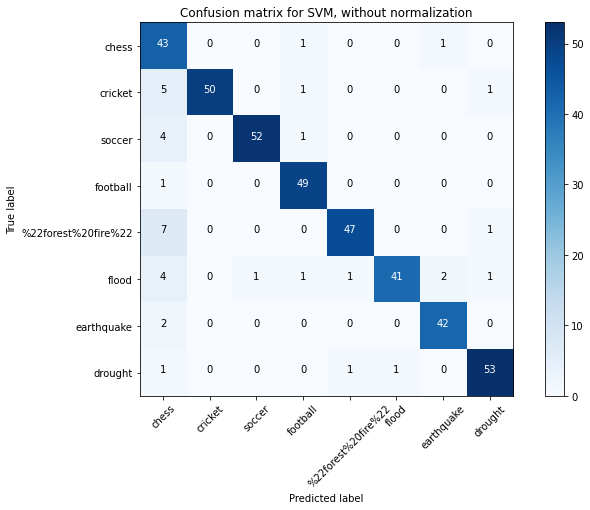

In [ ]:
OvO_svm_cnf_matrix = report_svm_multiclass(
    multiclass_svm_OvO,
    lsi_train_multiclass, 
    lsi_test_multiclass, 
    train_multiclass_svm_label, 
    test_multiclass_svm_label,
    map_row_to_class.keys()
)

### SVM One VS Rest multiclass classification

Accuracy: 0.9132530120481928
Precision: 0.9132530120481928
Recall: 0.9132530120481928
F-1 Score: 0.9132530120481928
Confusion matrix, without normalization
[[43  1  0  1  0  0  0  0]
 [ 3 52  0  1  0  0  0  1]
 [ 3  0 52  2  0  0  0  0]
 [ 1  0  0 49  0  0  0  0]
 [ 3  1  1  0 48  0  1  1]
 [ 4  0  1  1  1 41  2  1]
 [ 1  0  0  0  0  0 43  0]
 [ 1  0  0  0  3  1  0 51]]


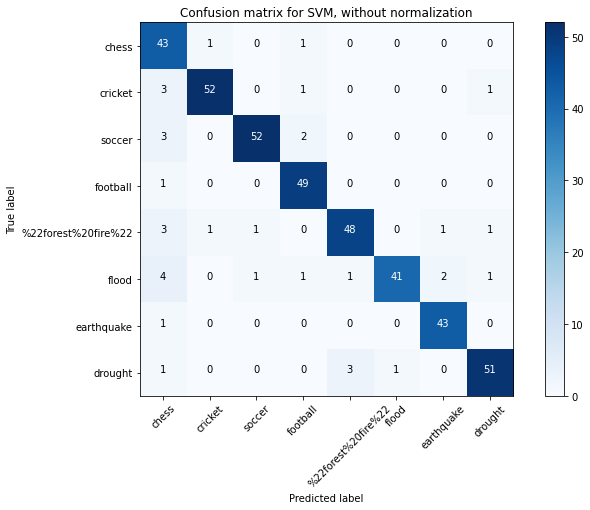

In [ ]:
OvR_svm_cnf_matrix = report_svm_multiclass(
    multiclass_svm_OvR,
    lsi_train_multiclass, 
    lsi_test_multiclass, 
    train_multiclass_svm_label, 
    test_multiclass_svm_label,
    map_row_to_class.keys()
)

### Naive Bayes multiclass classification

Accuracy: 0.8289156626506025
Precision: 0.8289156626506025
Recall: 0.8289156626506025
F-1 Score: 0.8289156626506025
Confusion matrix, without normalization
[[40  0  0  3  1  0  1  0]
 [12 41  2  1  0  1  0  0]
 [ 1  0 44  9  0  0  3  0]
 [ 0  0  0 50  0  0  0  0]
 [ 7  0  0  0 47  0  0  1]
 [ 2  0  1  1  3 33 10  1]
 [ 2  0  0  0  1  2 39  0]
 [ 2  0  0  0  2  2  0 50]]


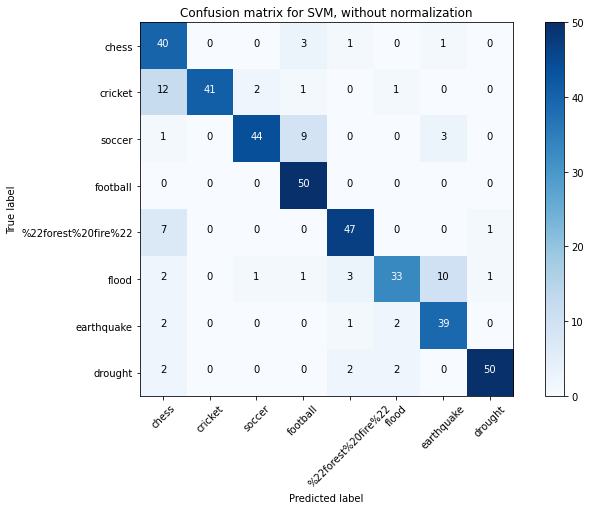

In [ ]:
gnb_svm_cnf_matrix = report_svm_multiclass(
    GaussianNB(),
    lsi_train_multiclass, 
    lsi_test_multiclass, 
    train_multiclass_svm_label, 
    test_multiclass_svm_label,
    map_row_to_class.keys()
)

## Comparing GNB & SVMs After Merging

In [ ]:
multiclass_svm_OvO = OneVsOneClassifier(SVC(random_state=42))
multiclass_svm_OvR = OneVsRestClassifier(SVC(random_state=42))

### Pre-processing (merging)

In [ ]:
# Merge soccer & football, flood & earthquake?
train_multiclass, test_multiclass = train_test_split(df[["full_text", "leaf_label"]], test_size = 0.2)
clean_dataset_by_label(train_multiclass, 'full_text', clean)
clean_dataset_by_label(test_multiclass, 'full_text', clean)
lemmatize_dataset_by_label(train_multiclass, 'full_text', lemmatize)
lemmatize_dataset_by_label(test_multiclass, 'full_text', lemmatize)

X_train_multiclass_tfidf_matrix, X_test_multiclass_tfidf_matrix = \
report_TFIDF_matrix_shape(train_multiclass, test_multiclass, 3, 'full_text')

lsi = TruncatedSVD(n_components = 50,n_iter = 10, random_state = 42)
lsi_train_multiclass = lsi.fit_transform(X_train_multiclass_tfidf_matrix)
lsi_test_multiclass = lsi.transform(X_test_multiclass_tfidf_matrix)

Cleaning dataset by label: 'full_text'
Completed cleaning in 0.506343 sec

Cleaning dataset by label: 'full_text'
Completed cleaning in 0.121888 sec

Lemmatizing dataset by label: 'full_text'
Completed Lemmatizing in 44.191488 sec

Lemmatizing dataset by label: 'full_text'
Completed Lemmatizing in 10.483280 sec

Shape of train matrix using min_df = 3 : (1657, 9636)
Shape of test matrix using min_df = 3 : (415, 9636)


In [ ]:
# Construct labels
map_merged = {
     "chess": 0, 
     "cricket": 1, 
     "soccer": 2, 
     "football": 3, 
     "%22forest%20fire%22": 4, 
     "flood": 5, 
     "earthquake": 5, 
     "drought": 6
}

merged_classes = [
  "chess", "cricket",
  "soccer",
  "football",
  "%22forest%20fire%22",
  "flood & earthquake",
  "drought"
]

train_multiclass_svm_merged = train_multiclass.replace({'leaf_label': map_merged})
train_multiclass_svm_label_merged = train_multiclass_svm_merged['leaf_label'].to_numpy()
print(train_multiclass_svm_label_merged.shape)

test_multiclass_svm_merged = test_multiclass.replace({'leaf_label': map_merged})
test_multiclass_svm_label_merged = test_multiclass_svm_merged['leaf_label'].to_numpy()
print(test_multiclass_svm_label_merged.shape)

(1657,)
(415,)


### SVM One VS One (merged) multiclass classification

Accuracy: 0.9204819277108434
Precision: 0.9204819277108434
Recall: 0.9204819277108434
F-1 Score: 0.9204819277108434
Confusion matrix, without normalization
[[ 47   0   0   0   0   1   0]
 [  3  48   0   1   2   1   0]
 [  2   0  47   0   1   1   0]
 [  2   0   0  48   0   0   0]
 [  1   0   0   1  40   2   2]
 [  8   0   0   0   0 109   1]
 [  3   0   0   0   0   1  43]]


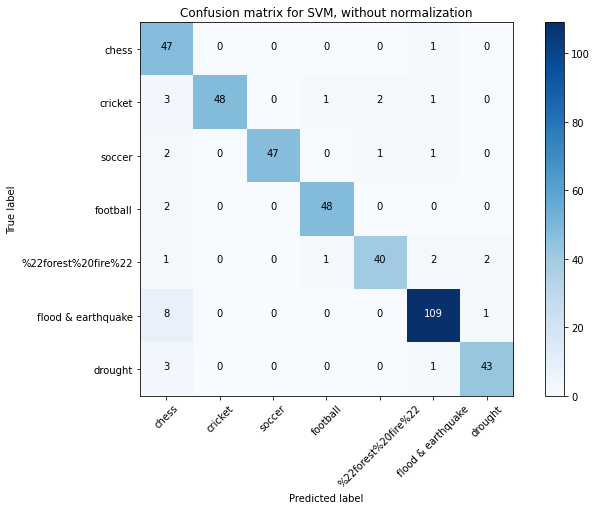

In [ ]:
OvO_svm_cnf_matrix_merged = report_svm_multiclass(
    multiclass_svm_OvO,
    lsi_train_multiclass, 
    lsi_test_multiclass, 
    train_multiclass_svm_label_merged, 
    test_multiclass_svm_label_merged,
    merged_classes
)

### SVM One VS Rest (merged) multiclass classification

Accuracy: 0.9253012048192771
Precision: 0.9253012048192771
Recall: 0.9253012048192771
F-1 Score: 0.9253012048192772
Confusion matrix, without normalization
[[ 43   0   1   1   1   1   1]
 [  2  50   0   1   1   1   0]
 [  2   0  48   0   1   0   0]
 [  0   0   0  49   0   1   0]
 [  0   1   0   0  40   2   3]
 [  6   0   0   0   1 109   2]
 [  2   0   0   0   0   0  45]]


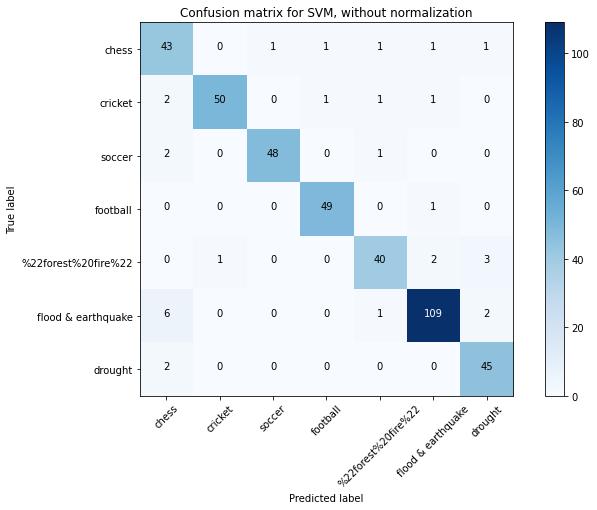

In [ ]:
OvR_svm_cnf_matrix_merged = report_svm_multiclass(
    multiclass_svm_OvR,
    lsi_train_multiclass, 
    lsi_test_multiclass, 
    train_multiclass_svm_label_merged, 
    test_multiclass_svm_label_merged,
    merged_classes
)

### SVM One VS One (merged) multiclass classification (balanced)

In [ ]:
multiclass_svm_OvO = OneVsOneClassifier(SVC(random_state=42, class_weight="balanced"))
multiclass_svm_OvR = OneVsRestClassifier(SVC(random_state=42, class_weight="balanced"))

Accuracy: 0.9228915662650602
Precision: 0.9228915662650602
Recall: 0.9228915662650602
F-1 Score: 0.9228915662650602
Confusion matrix, without normalization
[[ 48   0   0   0   0   0   0]
 [  3  49   0   1   2   0   0]
 [  2   0  48   0   1   0   0]
 [  2   0   0  48   0   0   0]
 [  1   0   0   1  42   0   2]
 [ 12   0   0   0   1 104   1]
 [  3   0   0   0   0   0  44]]


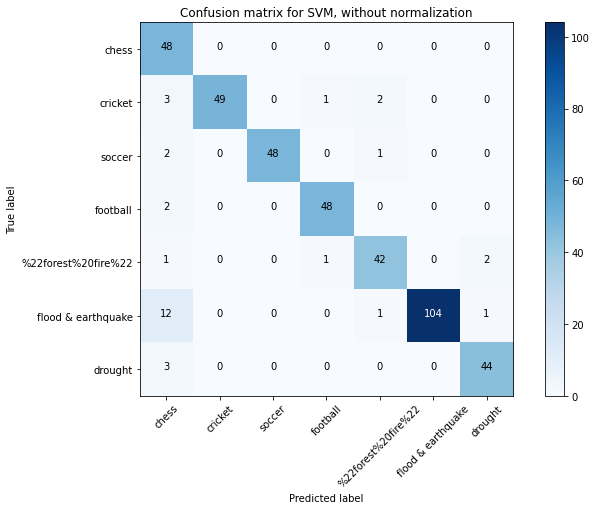

In [ ]:
OvO_svm_cnf_matrix_merged = report_svm_multiclass(
    multiclass_svm_OvO,
    lsi_train_multiclass, 
    lsi_test_multiclass, 
    train_multiclass_svm_label_merged, 
    test_multiclass_svm_label_merged,
    merged_classes
)

### SVM One VS Rest (merged) multiclass classification (balanced)

Accuracy: 0.9349397590361446
Precision: 0.9349397590361446
Recall: 0.9349397590361446
F-1 Score: 0.9349397590361446
Confusion matrix, without normalization
[[ 47   0   0   0   1   0   0]
 [  2  51   0   1   1   0   0]
 [  2   0  48   0   1   0   0]
 [  2   0   0  48   0   0   0]
 [  1   0   0   1  42   0   2]
 [  8   0   0   0   1 108   1]
 [  3   0   0   0   0   0  44]]


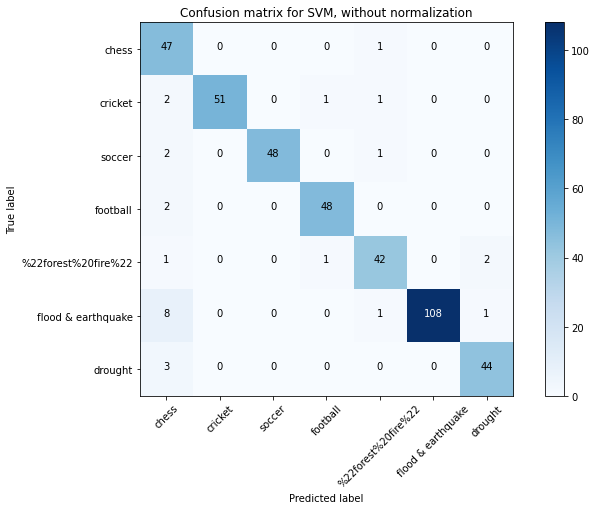

In [ ]:
OvR_svm_cnf_matrix_merged = report_svm_multiclass(
    multiclass_svm_OvR,
    lsi_train_multiclass, 
    lsi_test_multiclass, 
    train_multiclass_svm_label_merged, 
    test_multiclass_svm_label_merged,
    merged_classes
)

# Word Embedding (GLoVE)

## Load GLoVe pretrained embeddings

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip
#import pickle
#pickle.dump(embeddings_dict, open("./embeddings_dict.pkl","wb+"))
#embeddings_dict = pickle.load(open("./embeddings_dict.pkl","rb"))


--2022-01-24 23:55:01--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-01-24 23:55:01--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-01-24 23:55:01--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
import numpy as np
import pandas as pd
#Load data
!gdown --id 12VLfuWtCS3NiGLsHyn0YiWqD-mZvBu4z
df = pd.read_csv("Project_1_dataset_01_01_2022.csv")
print("Data Shape: ", df.shape)
def Load_GloVe(dim):
  GLOVE_DIR = "/content/glove.6B."+str(dim)+"d.txt"
  f = open(GLOVE_DIR)
  print('Loading GloVe from:', GLOVE_DIR,'...', end='')
  embeddings_dict = {}
  dimension_of_glove = dim
  for line in f:
      values = line.split()
      word = values[0]
      vector = np.asarray(values[1:], "float32")
      embeddings_dict[word] = vector

  return dim , embeddings_dict

Downloading...
From: https://drive.google.com/uc?id=12VLfuWtCS3NiGLsHyn0YiWqD-mZvBu4z
To: /content/Project_1_dataset_01_01_2022.csv
100% 8.13M/8.13M [00:00<00:00, 128MB/s]
Data Shape:  (2072, 9)


## Load Data

In [ ]:
# Load data
data = df[["keywords", "root_label"]]

In [ ]:
# Construct labels
mapping = {'sports': 1, 'climate': 0}
data_glove = data
data_glove = data_glove.replace({'root_label': mapping})
data_glove_label = data_glove['root_label'].to_numpy()

In [ ]:
#Basic Data clean
#convert keyword to keyword list
glove_list=[]

for word in data_glove["keywords"]:
  glove_list.append(' '.join(word[1:-1].replace("'","").replace(" ","").split(",")))

glove_list = pd.DataFrame(glove_list)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

validation_split = 0.2
max_len = 25

# Create vocabulary and tokenize
tokenizer = Tokenizer()
tokenizer.fit_on_texts(glove_list[0])
sequences = tokenizer.texts_to_sequences(glove_list[0])
#vocabulary list
word_index = tokenizer.word_index

data_seq = pad_sequences(sequences,maxlen=max_len)

#shuffle
indices = np.arange(data_seq.shape[0])
np.random.shuffle(indices)
data_seq = data_seq[indices]

#label_seq = label_seq[indices]
glove_label_ = data_glove_label[indices]
num_validation_samples = int(validation_split * data_seq.shape[0])

#Create training and testing matrix
X_train_glove = data_seq[:-num_validation_samples]
Y_train_glove = glove_label_[:-num_validation_samples]
X_test_glove = data_seq[-num_validation_samples:]
Y_test_glove = glove_label_[-num_validation_samples:]

num_words = len(word_index)

In [ ]:
from keras.layers import Dense, Input, Flatten, LSTM
from keras.layers import Reshape, Dropout, Concatenate
from keras.layers import Conv2D, MaxPool2D, Embedding
from keras.models import Model, Sequential
# Embedding Matrix
def Embedding_Matrix(num_words,dimension_of_glove,word_index,embeddings_dict):
  embedding_matrix = np.zeros((num_words + 1, dimension_of_glove))
  for word, i in word_index.items():
      embedding_vector = embeddings_dict.get(word)
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector
  return embedding_matrix
# Create Model
def GloVe_Model(num_words,dimension_of_glove,embedding_matrix,max_len):
  Embedding_layer = Embedding(num_words + 1,
                              dimension_of_glove,
                              weights = [embedding_matrix],
                              input_length = max_len,
                              trainable = False
                              )

  model_glove = Sequential()
  model_glove.add(Embedding_layer)
  model_glove.add(LSTM(units=32,dropout=0.2,recurrent_dropout=0.25))
  model_glove.add(Dense(1,activation='sigmoid'))
  model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  print(model_glove.summary())
  return model_glove

## Train GLoVe 300d

In [ ]:
# Load GloVe 300d
dimension_of_glove, embeddings_dict_300 = Load_GloVe(300)

Loading GloVe from: /content/glove.6B.300d.txt ...

In [ ]:
# GloVe model 300d
embedding_matrix_300 = Embedding_Matrix(num_words,dimension_of_glove,word_index,embeddings_dict_300)
model_glove_300 = GloVe_Model(num_words,dimension_of_glove,embedding_matrix_300,max_len)

In [ ]:
# Train Glove
history_300 = model_glove_300.fit(X_train_glove, Y_train_glove,
          batch_size=32,
          epochs=15,
          validation_data=(X_test_glove, Y_test_glove))


In [ ]:
# Result 300d
acc_300 = history_300.history['accuracy']
loss_300 = history_300.history['loss']
val_acc_300 = history_300.history['val_accuracy']
val_loss_300 = history_300.history['val_loss']

## Train GLoVe 50d

In [ ]:
# Load 50d Glove
dimension_of_glove, embeddings_dict_50 = Load_GloVe(50)

Loading GloVe from: /content/glove.6B.50d.txt ...

In [ ]:
# GloVe model 50d
embedding_matrix_50 = Embedding_Matrix(num_words,dimension_of_glove,word_index,embeddings_dict_50)
model_glove_50 = GloVe_Model(num_words,dimension_of_glove,embedding_matrix_50,max_len)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 25, 50)            412550    
                                                                 
 lstm_1 (LSTM)               (None, 32)                10624     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 423,207
Trainable params: 10,657
Non-trainable params: 412,550
_________________________________________________________________
None


In [ ]:
# Train Glove
history_50 = model_glove_50.fit(X_train_glove, Y_train_glove,
          batch_size=32,
          epochs=15,
          validation_data=(X_test_glove, Y_test_glove))

Epoch 1/15
52/52 [==============================] - 11s 151ms/step - loss: 0.4258 - accuracy: 0.8643 - val_loss: 0.2382 - val_accuracy: 0.9058
Epoch 2/15
52/52 [==============================] - 7s 140ms/step - loss: 0.2012 - accuracy: 0.9240 - val_loss: 0.1793 - val_accuracy: 0.9227
Epoch 3/15
52/52 [==============================] - 8s 147ms/step - loss: 0.1637 - accuracy: 0.9385 - val_loss: 0.1637 - val_accuracy: 0.9348
Epoch 4/15
52/52 [==============================] - 8s 145ms/step - loss: 0.1461 - accuracy: 0.9373 - val_loss: 0.1709 - val_accuracy: 0.9300
Epoch 5/15
52/52 [==============================] - 8s 145ms/step - loss: 0.1378 - accuracy: 0.9427 - val_loss: 0.1429 - val_accuracy: 0.9348
Epoch 6/15
52/52 [==============================] - 8s 145ms/step - loss: 0.1302 - accuracy: 0.9481 - val_loss: 0.1314 - val_accuracy: 0.9469
Epoch 7/15
52/52 [==============================] - 8s 146ms/step - loss: 0.1088 - accuracy: 0.9578 - val_loss: 0.1695 - val_accuracy: 0.9300
Epoch

In [ ]:
# Result 50d
acc_50 = history_50.history['accuracy']
loss_50 = history_50.history['loss']
val_acc_50 = history_50.history['val_accuracy']
val_loss_50 = history_50.history['val_loss']

## Train GLoVe 100d

In [ ]:
# Load 100d Glove
dimension_of_glove, embeddings_dict_100 = Load_GloVe(100)

Loading GloVe from: /content/glove.6B.100d.txt ...

In [ ]:
# GloVe model 100d
embedding_matrix_100 = Embedding_Matrix(num_words,dimension_of_glove,word_index,embeddings_dict_100)
model_glove_100 = GloVe_Model(num_words,dimension_of_glove,embedding_matrix_100,max_len)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 25, 100)           825100    
                                                                 
 lstm_2 (LSTM)               (None, 32)                17024     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 842,157
Trainable params: 17,057
Non-trainable params: 825,100
_________________________________________________________________
None


In [ ]:
# Train Glove
history_100 = model_glove_100.fit(X_train_glove, Y_train_glove,
          batch_size=32,
          epochs=15,
          validation_data=(X_test_glove, Y_test_glove))

Epoch 1/15
52/52 [==============================] - 11s 150ms/step - loss: 0.3927 - accuracy: 0.8516 - val_loss: 0.2164 - val_accuracy: 0.9155
Epoch 2/15
52/52 [==============================] - 8s 145ms/step - loss: 0.1758 - accuracy: 0.9270 - val_loss: 0.1720 - val_accuracy: 0.9324
Epoch 3/15
52/52 [==============================] - 8s 145ms/step - loss: 0.1427 - accuracy: 0.9445 - val_loss: 0.1517 - val_accuracy: 0.9372
Epoch 4/15
52/52 [==============================] - 8s 144ms/step - loss: 0.1245 - accuracy: 0.9530 - val_loss: 0.1423 - val_accuracy: 0.9372
Epoch 5/15
52/52 [==============================] - 8s 144ms/step - loss: 0.1014 - accuracy: 0.9620 - val_loss: 0.1287 - val_accuracy: 0.9420
Epoch 6/15
52/52 [==============================] - 8s 145ms/step - loss: 0.0872 - accuracy: 0.9698 - val_loss: 0.1516 - val_accuracy: 0.9300
Epoch 7/15
52/52 [==============================] - 8s 146ms/step - loss: 0.0806 - accuracy: 0.9686 - val_loss: 0.1252 - val_accuracy: 0.9444
Epoch

In [ ]:
# Result 100d
acc_100 = history_100.history['accuracy']
loss_100 = history_100.history['loss']
val_acc_100 = history_100.history['val_accuracy']
val_loss_100 = history_100.history['val_loss']

## Train GLoVe 200d

In [ ]:
# Load 200d Glove
dimension_of_glove, embeddings_dict_200 = Load_GloVe(200)

Loading GloVe from: /content/glove.6B.200d.txt ...

In [ ]:
# GloVe model 200d
embedding_matrix_200 = Embedding_Matrix(num_words,dimension_of_glove,word_index,embeddings_dict_200)
model_glove_200 = GloVe_Model(num_words,dimension_of_glove,embedding_matrix_200,max_len)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 25, 200)           1650200   
                                                                 
 lstm_3 (LSTM)               (None, 32)                29824     
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,680,057
Trainable params: 29,857
Non-trainable params: 1,650,200
_________________________________________________________________
None


In [ ]:
# Train Glove
history_200 = model_glove_200.fit(X_train_glove, Y_train_glove,
          batch_size=32,
          epochs=15,
          validation_data=(X_test_glove, Y_test_glove))

Epoch 1/15
52/52 [==============================] - 11s 148ms/step - loss: 0.3945 - accuracy: 0.8426 - val_loss: 0.1886 - val_accuracy: 0.9300
Epoch 2/15
52/52 [==============================] - 7s 139ms/step - loss: 0.1553 - accuracy: 0.9379 - val_loss: 0.1382 - val_accuracy: 0.9444
Epoch 3/15
52/52 [==============================] - 7s 140ms/step - loss: 0.1163 - accuracy: 0.9584 - val_loss: 0.1158 - val_accuracy: 0.9469
Epoch 4/15
52/52 [==============================] - 7s 143ms/step - loss: 0.0936 - accuracy: 0.9686 - val_loss: 0.1106 - val_accuracy: 0.9517
Epoch 5/15
52/52 [==============================] - 7s 141ms/step - loss: 0.0755 - accuracy: 0.9747 - val_loss: 0.1347 - val_accuracy: 0.9396
Epoch 6/15
52/52 [==============================] - 7s 141ms/step - loss: 0.0655 - accuracy: 0.9771 - val_loss: 0.0989 - val_accuracy: 0.9517
Epoch 7/15
52/52 [==============================] - 7s 144ms/step - loss: 0.0498 - accuracy: 0.9837 - val_loss: 0.1176 - val_accuracy: 0.9493
Epoch

In [ ]:
# Result 200d
acc_200 = history_200.history['accuracy']
loss_200 = history_200.history['loss']
val_acc_200 = history_200.history['val_accuracy']
val_loss_200 = history_200.history['val_loss']

## Accuracy v. Pretrained Dimension of GLoVe

In [ ]:
d = {'50d':[acc_50[-1],val_acc_50[-1]],
     '100d':[acc_100[-1],val_acc_100[-1]],
     '200d':[acc_200[-1],val_acc_200[-1]],
     '300d':[acc_300[-1],val_acc_300[-1]]
     }
     
final_result_glove = pd.DataFrame(data=d, index=['Training Accuracy','Validation Accuracy'])

print(final_result_glove)

                          50d      100d      200d      300d
Training Accuracy    0.978287  0.990350  0.995778  0.996984
Validation Accuracy  0.946860  0.956522  0.954106  0.951691


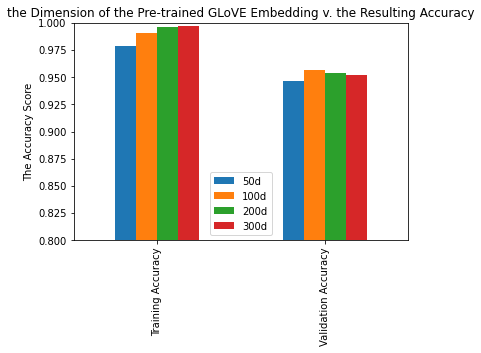

In [ ]:
import matplotlib.pyplot as plt
final_result_glove.plot(kind="bar",title="the Dimension of the Pre-trained GLoVE Embedding v. the Resulting Accuracy",ylim = [0.8,1.0],ylabel= "The Accuracy Score")

## Importing UMAP

In [ ]:
!pip uninstall umap
!pip install umap-learn
!pip install umap-learn[plot]

In [ ]:
import umap.umap_ as umap
import umap.plot

## Clustering

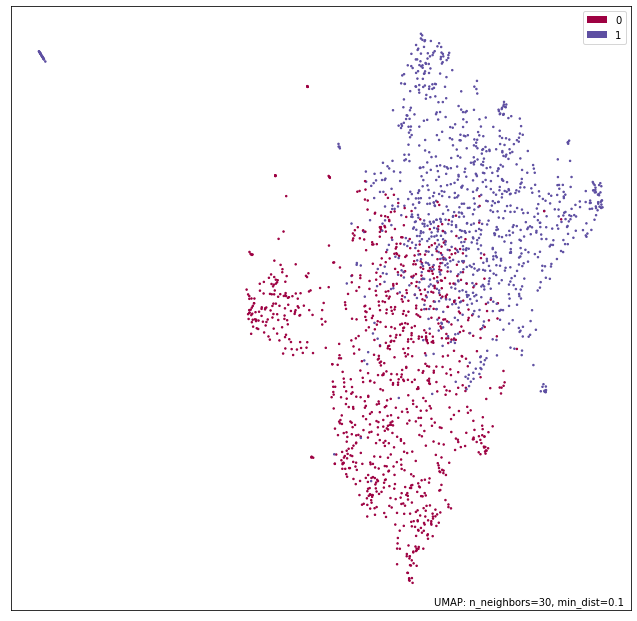

In [ ]:
# cluster glove embedding
intermediate_layer_model = Model(inputs=model_glove_300.input,
                                       outputs=model_glove_300.layers[0].output)
emb_output = intermediate_layer_model(data_seq)

embedding_matrix_300 = emb_output.numpy().reshape(2072,-1)
normalized_embedding_300 = embedding_matrix_300 / np.linalg.norm(embedding_matrix_300)

mapper = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1).fit(normalized_embedding_300)
umap.plot.points(mapper, labels=glove_label_)

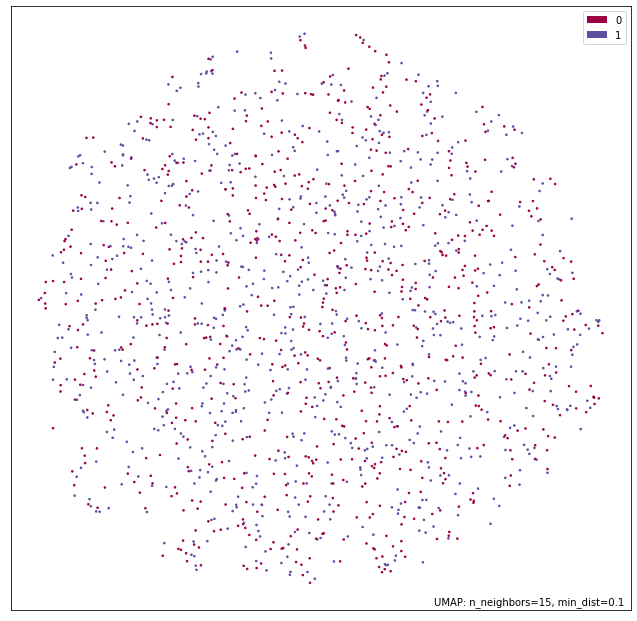

In [ ]:
# random variable
random_embedding = np.random.rand(
  X_train_glove.shape[0],
  X_train_glove.shape[1]
)
normalized_embedding_random = random_embedding / np.linalg.norm(random_embedding)

# normalized_embedding_random
normalized_embedding_random = random_embedding / np.linalg.norm(random_embedding)
mapper_random = umap.UMAP(random_state=42)
mapper_random.fit(normalized_embedding_random)
umap.plot.points(mapper_random, labels=np.array([random.randint(0,1) for _ in range(len(Y_train_glove))]))